In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control import cost_functions as cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

In [2]:
# define plot function for later convenience
def plot_singlenode(model, duration, dt, state, target, control, input, weight_array=[], M=1):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    for m in range(M-1):
        model.run()
        state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
        ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
        ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

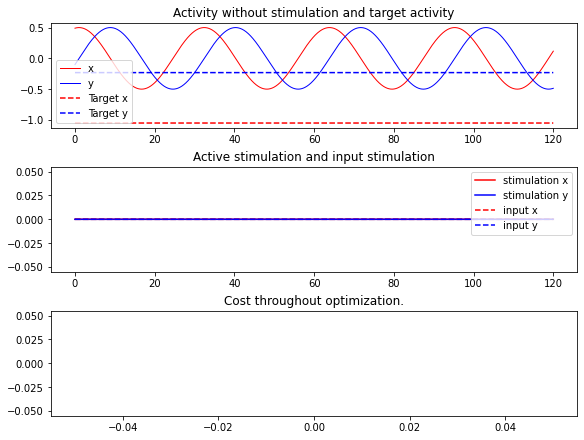

(1, 2, 12001)


In [4]:
hopf = HopfModel()
hopf.params.sigma_ou = 0.
hopf.params.x_ou_mean = -1.

hopf.params["dt"] /= 10.
dt = hopf.params["dt"]
duration = 120.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

hopf.params["duration"] = duration
x_init = 0.
y_init = 0.
hopf.params["xs_init"] = np.array([[x_init]])
hopf.params["ys_init"] = np.array([[y_init]])
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
hopf.run()

x_init_down = np.array([[hopf.x[0,-1]]])
y_init_down = np.array([[hopf.y[0,-1]]])
hopf.params["xs_init"] = x_init_down
hopf.params["ys_init"] = y_init_down
hopf.run()

target = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

hopf.params.x_ou_mean = 0.
hopf.params["xs_init"] = np.array([[0.1]])
hopf.params["ys_init"] = np.array([[y_init]])
hopf.run()

x_init_osc = np.array([[hopf.x[0,-1]]])
y_init_osc = np.array([[hopf.y[0,-1]]])
hopf.params["xs_init"] = x_init_osc
hopf.params["ys_init"] = y_init_osc
hopf.run()

state = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

plot_singlenode(hopf, duration, dt, state, target, zero_control, zero_control)

Compute control for a deterministic system
Cost in iteration 0: 960.0264853442617
Cost in iteration 1: 881.8416550515943
Cost in iteration 2: 720.2657630145432
Cost in iteration 3: 424.9468731505624
Cost in iteration 4: 388.29451986530523
Cost in iteration 5: 150.1584055608988
Cost in iteration 6: 112.96206415807539
Cost in iteration 7: 68.4585666805975
Cost in iteration 8: 46.6923489956684
Cost in iteration 9: 35.17921941017726
Cost in iteration 10: 27.872780069812954
Cost in iteration 11: 23.46486070703425
Cost in iteration 12: 21.2653416661545
Cost in iteration 13: 17.08221559997554
Cost in iteration 14: 16.13168447924695
Cost in iteration 15: 13.813982009620853
Cost in iteration 16: 13.168285338129085
Cost in iteration 17: 12.95099291818981
Cost in iteration 18: 12.53928120567999
Cost in iteration 19: 12.334532491455782
Cost in iteration 20: 12.185070841413848
Cost in iteration 21: 12.012481180116156
Cost in iteration 22: 12.003882584158612
Cost in iteration 23: 11.80630189046372
C

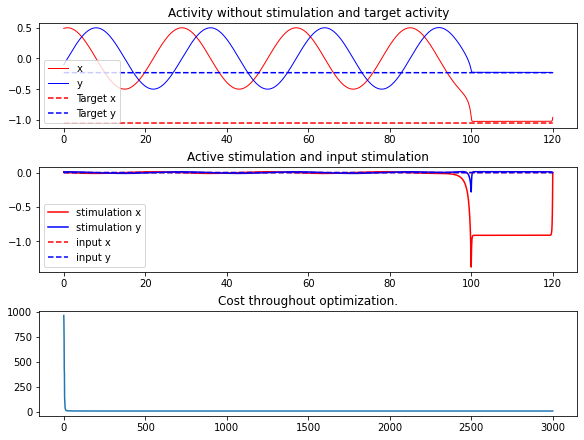

In [7]:
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
w2 = 1e-2
wp = 1.
printarray = np.concatenate( (np.arange(0,101,10), np.arange(200,1001,100), np.arange(2000,10001,1000)) )
hopf_controlled_noisefree = oc_hopf.OcHopf(hopf, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=(10000,None))

# We run 100 iterations of the optimal control gradient descent algorithm
hopf_controlled_noisefree.optimize(3000)

state = hopf_controlled_noisefree.get_xs()
control_noisefree = hopf_controlled_noisefree.control

plot_singlenode(hopf_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, hopf_controlled_noisefree.cost_history)


Compute control for a deterministic system
Cost in iteration 0: 9.42992175951249
Cost in iteration 1: 9.429921759231565
Cost in iteration 2: 9.429921741685051
Cost in iteration 3: 9.429921736935162
Cost in iteration 4: 9.42992173666725
Cost in iteration 5: 9.429921722789615
Cost in iteration 6: 9.429921717368465
Cost in iteration 7: 9.429921715247827
Cost in iteration 8: 9.429921704078048
Cost in iteration 9: 9.429921698172747
Cost in iteration 10: 9.429921694705387
Cost in iteration 11: 9.429921685518252
Cost in iteration 12: 9.429921681772225
Cost in iteration 13: 9.429921667795567
Cost in iteration 14: 9.429921662493545
Cost in iteration 15: 9.429921660551534
Cost in iteration 16: 9.42992164929644
Cost in iteration 17: 9.429921643505667
Cost in iteration 18: 9.429921640204448
Cost in iteration 19: 9.429921630948062
Cost in iteration 20: 9.429921627620137
Cost in iteration 21: 9.429921613453104
Cost in iteration 22: 9.429921608286932
Cost in iteration 23: 9.42992160656985
Cost in ite

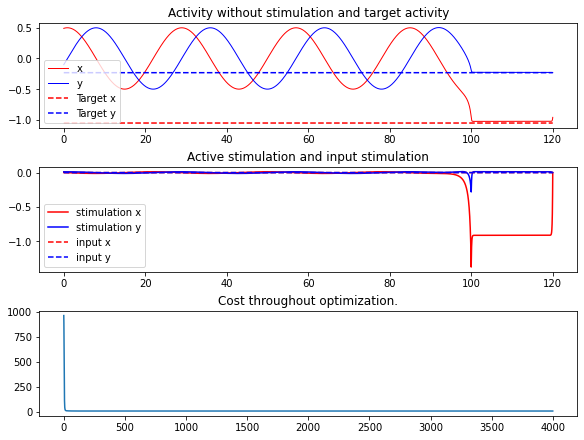

In [8]:
hopf_controlled_noisefree.optimize(1000)

state = hopf_controlled_noisefree.get_xs()
control_noisefree = hopf_controlled_noisefree.control

plot_singlenode(hopf_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, hopf_controlled_noisefree.cost_history)

In [26]:
sigma_array = [2. * 1e-2, 1. * 1e-1]
M_array = [4,20,100]

weights = np.zeros(( len(sigma_array) ))
controls = [ [None, None, None], [None, None, None]]
costs_history = controls.copy()
costs = np.zeros(( len(sigma_array), len(M_array)+1 ))

In [27]:
hopf_noise = HopfModel()
hopf_noise.params.dt = dt
hopf_noise.params.sigma_ou = 0.
hopf_noise.params.x_ou_mean = 0.

In [28]:
hopf_noise.params.duration = 1. * 1e6
hopf_noise.params["xs_init"] = np.array([[x_init_down]])
hopf_noise.params["ys_init"] = np.array([[y_init_down]])
hopf_noise.params["x_ext"] = zero_input
hopf_noise.params["y_ext"] = zero_input

for i_s in range(len(sigma_array)):
    hopf_noise.params.sigma_ou = sigma_array[i_s]

    hopf_noise.run()
    weights[i_s] = 1. / (np.std(hopf_noise.x[0,100:]) + np.std(hopf_noise.y[0,100:]) )

print(weights)

# [45.99594752  9.07230569]

[1.39957218 1.12036221]


In [36]:
# controls = [ [None, None, None], [None, None, None]]

# print(controls[0][0].shape, controls[0][1].shape, controls[0][2].shape)
# print(controls[1][0].shape, controls[1][1].shape)
print(controls[1][2].shape)
print(controls[1][2])


(1, 2, 12001)
[[[ 0.90745948  0.90682984  0.90618632 ... -0.02578181 -0.01292146
    0.        ]
  [ 1.66685422  1.66810615  1.66934884 ... -0.00428371 -0.00215828
    0.        ]]]


In [37]:
hopf_noise.params.duration = duration
hopf_noise.params["xs_init"] = x_init_osc
hopf_noise.params["ys_init"] = y_init_osc

hopf_noise.params.x_ou_mean = 0.
M_val = 500
max_iterations = 200
hopf_noise.run()
printarray = np.concatenate( (np.arange(0,100,10), np.arange(0,1001,100)) )

costs_history = [ [None, None, None], [None, None, None]]

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):

        if i_m in [0,1]:
            continue

        if i_s in [0]:
            continue

        if type(costs_history[i_s][i_m]) != type(None):
            continue

        print("--------------------------------------------------------------")
        print("---------------------------- sigma, M = ", sigma_array[i_s], M_array[i_m])

        hopf_noise.params["x_ext"] = zero_input
        hopf_noise.params["y_ext"] = zero_input
        hopf_noise.params.sigma_ou = sigma_array[i_s]

        hopf_controlled_models = oc_hopf.OcHopf(hopf_noise, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=(1000,None),
                                    M=int(M_array[i_m]),
                                    #M = 10,
                                    M_validation=M_val, validate_per_step=True)

        # We run 100 iterations of the optimal control gradient descent algorithm
        hopf_controlled_models.optimize(max_iterations)

        state = hopf_controlled_models.get_xs()
        controls[i_s][i_m] = hopf_controlled_models.control
        costs_history[i_s][i_m] = hopf_controlled_models.cost_history
        costs[i_s][i_m+1] = hopf_controlled_models.cost_validation

        # plot_singlenode(hopf_controlled_models.model, duration, dt, state, target, controls[i_s][i_m], zero_control, hopf_controlled_models.cost_history, M=10)

--------------------------------------------------------------
---------------------------- sigma, M =  0.1 100
Compute control for a noisy system
Mean cost in iteration 0: 8670.675051182301


In [19]:
hopf_plot = HopfModel()
hopf_plot.params.x_ou_mean = 0.
hopf_plot.params.dt = dt

hopf_plot.params["duration"] = duration
hopf_plot.params["xs_init"] = x_init_osc
hopf_plot.params["ys_init"] = y_init_osc


In [20]:
for i_s in range(len(sigma_array)):

    print(i_s)

    hopf_plot.params.sigma_ou = sigma_array[i_s]

    hopf_plot.params["x_ext"] = control_noisefree[:,0,:]
    hopf_plot.params["y_ext"] = control_noisefree[:,1,:]

    cost_validation = 0.0
    energy_cost = cost_functions.energy_cost(control_noisefree, w_2=w2)

    for m in range(M_val):
        hopf_plot.run()
        state = np.concatenate((np.concatenate( (hopf_plot.params["xs_init"], hopf_plot.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf_plot.x, hopf_plot.y), axis=1)), axis=2)
        precision_cost = cost_functions.precision_cost(target, state, wp, 1, np.ones( (1, 2)), [1000,-1])
        cost_validation += precision_cost + energy_cost

    costs[i_s][0] = cost_validation/M_val

print(costs[0][0], costs[1][0])

0
1
7097.405438114317 7943.779306322589


TypeError: list indices must be integers or slices, not tuple

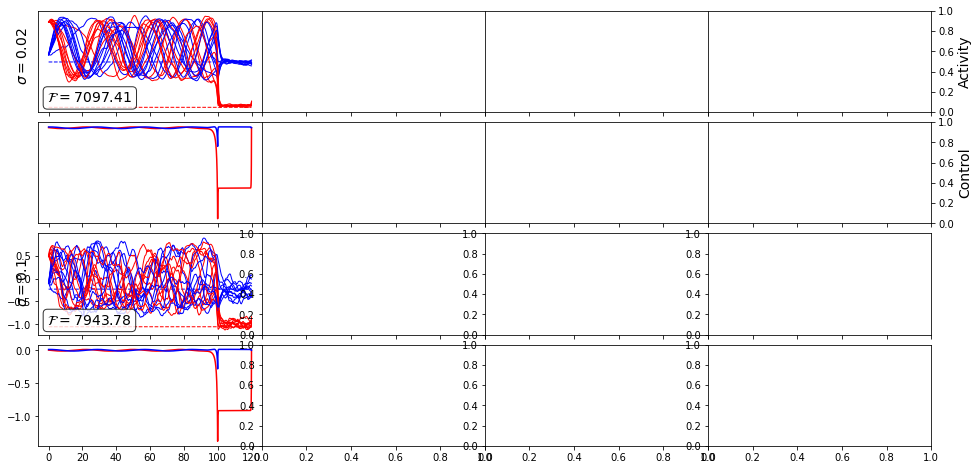

In [21]:
row, col = int(2*len(sigma_array)), int(len(M_array)+1)

fig = plt.figure(figsize=(4*col,2*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fs = 14
savepath = '..' + os.sep + '..' + os.sep + '..' + os.sep + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + '2022_Wittenberg' + os.sep + 'talk' + os.sep + 'talk' + os.sep + 'images'

time_array = np.arange(0, duration+dt, dt)

for i_s in range(len(sigma_array)):
    ax[2*i_s, 0].text(-0.1, 0.3, r'$\sigma = $'+ "{}".format(sigma_array[i_s]),
    transform=ax[2*i_s, 0].transAxes, rotation='vertical', fontsize=fs)

    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,0,:], color=color_x)
    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,1,:], color=color_y)
    
    hopf_plot.params.sigma_ou = sigma_array[i_s]

    hopf_plot.params["x_ext"] = control_noisefree[:,0,:]
    hopf_plot.params["y_ext"] = control_noisefree[:,1,:]

    ax[2*i_s, 0].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
    ax[2*i_s, 0].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

    for m in range(10):
        hopf_plot.run()
        ax[2*i_s, 0].plot(time_array[1:], hopf_plot.x[0,:], color=color_x, linewidth=1)
        ax[2*i_s, 0].plot(time_array[1:], hopf_plot.y[0,:], color=color_y, linewidth=1)

    ax[2*i_s, 0].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][0]),
        transform=ax[2*i_s, 0].transAxes, fontsize=fs, bbox=box_props)

    for i_m in range(len(M_array)):

        if i_m in [0,1]:
            continue

        if i_s in [0]:
            continue

        
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,0,:], color=color_x)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,1,:], color=color_y)

        ax[2*i_s, i_m+1].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][i_m+1]),
        transform=ax[2*i_s, i_m+1].transAxes, fontsize=fs, bbox=box_props)

        hopf_plot.params["x_ext"] = controls[i_s][i_m][:,0,:]
        hopf_plot.params["y_ext"] = controls[i_s][i_m][:,1,:]

        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

        for m in range(10):
            hopf_plot.run()
            ax[2*i_s, i_m+1].plot(time_array[1:], hopf_plot.x[0,:], color=color_x, linewidth=1)
            ax[2*i_s, i_m+1].plot(time_array[1:], hopf_plot.y[0,:], color=color_y, linewidth=1)



    for k in range(col-1):
        ax[2*i_s,k].set_yticks([])
        ax[2*i_s+1,k].set_yticks([])
    
    ax[2*i_s,-1].yaxis.tick_right()
    ax[2*i_s+1,-1].yaxis.tick_right()

    ax[2*i_s,-1].set_ylabel("Activity", fontsize=fs)
    ax[2*i_s,-1].yaxis.set_label_position("right")
    ax[2*i_s+1,-1].set_ylabel("Control", fontsize=fs)
    ax[2*i_s+1,-1].yaxis.set_label_position("right")


for k in range(col):
    for j in range(row-1):
        ax[j,k].set_xticks([])
        ax[j,k].set_xlim([0,duration])
        ax[j,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xticks(np.arange(0,120,20))
    ax[-1,k].set_xlim([0,duration])
    ax[-1,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xlabel("Time [ms]", fontsize=fs)

for i_m in range(len(M_array)):
    ax[0,i_m+1].set_title(r"$M=$" + "{}".format(M_array[i_m]), fontsize=fs)

ax[0,0].set_title(r"Deterministic OC", fontsize=fs)

#fig.savefig(os.path.join(savepath, 'Hopf_osc_down_traces.jpg'), bbox_inches='tight')
plt.show()


NameError: name 'fs' is not defined

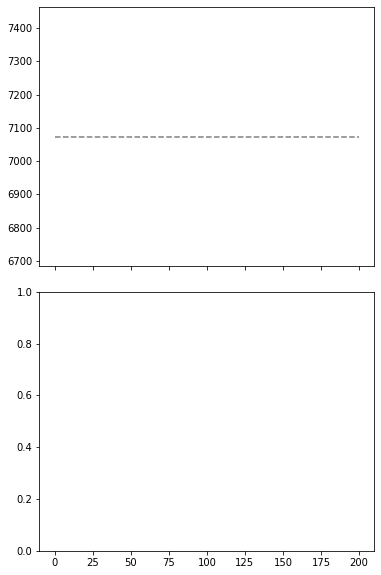

In [18]:
row, col = len(sigma_array), 1

fig = plt.figure(figsize=(6,5*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):

        if i_m in [0,1]:
            continue

        if i_s in [0]:
            continue

        ax[i_s].plot(costs_history[i_s][i_m], label=r'$M=$' + '{}'.format(M_array[i_m]))

    ax[i_s].hlines(costs[i_s,0], 0, max_iterations, label='DOC', linestyle='--', color='grey')

    ax[i_s].text(-0.05, 0.4, r'$\sigma = $'+ "{}".format(sigma_array[i_s]), transform=ax[i_s].transAxes, rotation='vertical', fontsize=fs)

    ax[i_s].set_ylabel(r'Total cost $\mathcal{F}$', fontsize=fs)
    ax[i_s].yaxis.set_label_position("right")
    ax[i_s].yaxis.tick_right()
    ax[i_s].tick_params(axis='both', labelsize=fs)
    ax[i_s].set_xlim([0,max_iterations])
    ax[i_s].set_yscale('log')
    ax[i_s].set_ylim(1., 200)

ax[0].legend(loc='upper right', fontsize=fs)
ax[-1].set_xlabel("Iteration", fontsize=fs)


#fig.savefig(os.path.join(savepath, 'Hopf_osc_down_cost.jpg'), bbox_inches='tight')
plt.show()